In [1]:
# Core imports
import kagglehub
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from imblearn.over_sampling import SMOTE  # (Potential future use for imbalance handling)
from imblearn.ensemble import BalancedRandomForestClassifier  # (Currently unused)
# from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

/Users/mahabub.ahmed.eee/Documents/MLOps/MLOps-Spotify/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load data from kaggle
data_path=kagglehub.dataset_download("amitanshjoshi/spotify-1million-tracks")
df=pd.read_csv(f"{data_path}/spotify_data.csv")

In [3]:
df.head()

,Unnamed: 0,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3
1,1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4
2,2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4
3,3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4
4,4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4


In [4]:
df.shape

(1159764, 20)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1159764 entries, 0 to 1159763
Data columns (total 20 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Unnamed: 0        1159764 non-null  int64  
 1   artist_name       1159749 non-null  object 
 2   track_name        1159763 non-null  object 
 3   track_id          1159764 non-null  object 
 4   popularity        1159764 non-null  int64  
 5   year              1159764 non-null  int64  
 6   genre             1159764 non-null  object 
 7   danceability      1159764 non-null  float64
 8   energy            1159764 non-null  float64
 9   key               1159764 non-null  int64  
 10  loudness          1159764 non-null  float64
 11  mode              1159764 non-null  int64  
 12  speechiness       1159764 non-null  float64
 13  acousticness      1159764 non-null  float64
 14  instrumentalness  1159764 non-null  float64
 15  liveness          1159764 non-null  float64
 16  

In [6]:
df.describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1159764.0,659061.322,428549.154,0.0,289940.750,579881.500,1031689.250,1473395.000
popularity,1159764.0,18.383,15.886,0.0,5.000,15.000,29.000,100.000
year,1159764.0,2011.955,6.804,2000.0,2006.000,2012.000,2018.000,2023.000
danceability,1159764.0,0.537,0.184,0.0,0.413,0.550,0.677,0.993
energy,1159764.0,0.640,0.271,0.0,0.454,0.694,0.873,1.000
key,1159764.0,5.288,3.555,0.0,2.000,5.000,8.000,11.000
loudness,1159764.0,-8.981,5.682,-58.1,-10.829,-7.450,-5.276,6.172
mode,1159764.0,0.635,0.482,0.0,0.000,1.000,1.000,1.000
speechiness,1159764.0,0.093,0.127,0.0,0.037,0.051,0.089,0.971
acousticness,1159764.0,0.322,0.355,0.0,0.006,0.147,0.640,0.996


In [7]:
df.isna().sum()

Unnamed: 0           0
artist_name         15
track_name           1
track_id             0
popularity           0
year                 0
genre                0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
duration_ms          0
time_signature       0
dtype: int64

In [11]:
df_clean = df.copy()

# Handle missing values
df_clean['artist_name'] = df_clean['artist_name'].fillna('Unknown Artist')
df_clean['track_name'] = df_clean['track_name'].fillna('Unknown Track')

# Calculate median
popularity_median = df_clean['popularity'].median()
print(f"Median popularity: {popularity_median}")

# Create binary target
df_clean['is_popular'] = (df_clean['popularity'] > popularity_median).astype(int)

# Check class distribution
print(df_clean['is_popular'].value_counts(normalize=True))

Median popularity: 15.0
is_popular
0    0.505996
1    0.494004
Name: proportion, dtype: float64


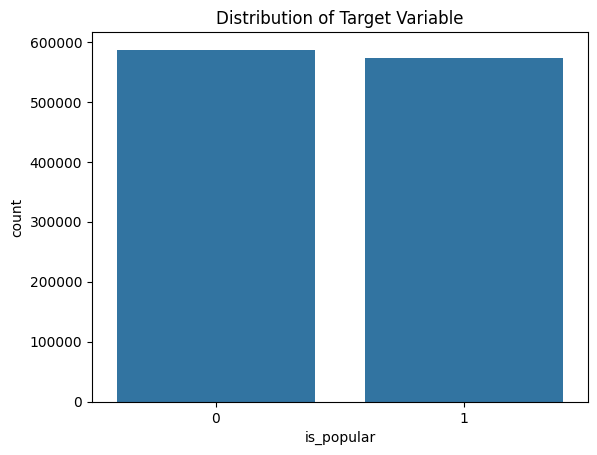

In [13]:
#show the ratio of target variable
df_clean['is_popular'].value_counts(normalize=True)
sns.countplot(x='is_popular', data=df_clean)
plt.title('Distribution of Target Variable')
plt.show()
